In [1]:
from Datasets import CountceptionPickleDataset, CountceptionRawDataset
from matplotlib import pyplot as plt
from Models import CountCeptionModel
from notebookTrain import *

model = CountCeptionModel()
model = model.load_from_checkpoint("C:/Users/gator/FullerLab/BrainStemSegmenter/lightning_logs/version_35/checkpoints/epoch=999-step=10000.ckpt")
# model.eval()
model = model.to(torch.device("cpu"))

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:

image_path = "C:/Users/gator/OneDrive - University of Florida/10x images for quantification/Manual Counts copy/TO TEST CODE/2sBc1r1 PM 3C.tif"
mask_path = "C:/Users/gator/OneDrive - University of Florida/10x images for quantification/Manual Counts copy/TO TEST CODE/2sBc1r1 PM 3C Mask.png"
image = imread(image_path)
mask = imread(mask_path)
tensor_img = [transforms.ToTensor()(image)]
tensor_img = torch.stack(tensor_img)

In [36]:
pred = model.forward(tensor_img)
pred_tensor = pred
pred = pred[0].detach().permute(1,2,0)

(2453, 2291)


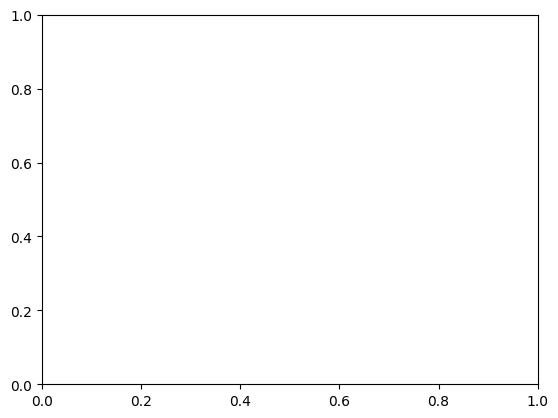

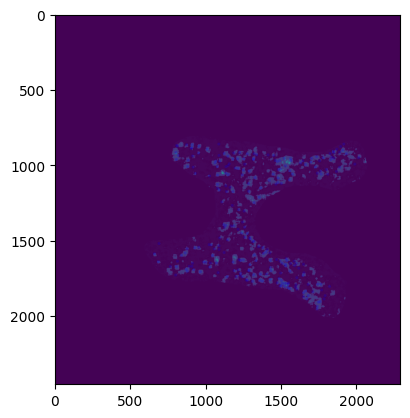

In [56]:
from roifile import ImagejRoi
roi = ImagejRoi.fromfile("C:/Users/gator/OneDrive - University of Florida/10x images for quantification/Manual Counts copy/TO TEST CODE/2sBc1r1 PM NEUN.roi")
coords = roi.coordinates()
plt.cla()
offset = 600
f, axarr = plt.subplots(1,1)
patch_size=32
for coord in coords:
        circle = plt.Circle((coord[0]+int(patch_size/2), coord[1]+int(patch_size/2)), 10 ,alpha=0.2, fill = True , color="blue", linewidth=0)
        axarr.add_artist(circle)

x, y, c = image.shape
padded_mask = np.pad(mask[:,:],int(patch_size/2), "constant", constant_values=(0))
# NEUN_image_cropped = np.pad(image[offset:x-100,offset:y-100,1]*3,int(patch_size/2), "constant")
NEUN_image_cropped = np.pad(image[:,:,1]*3,int(patch_size/2), "constant")

print(NEUN_image_cropped.shape)
axarr.imshow(np.dstack([NEUN_image_cropped,NEUN_image_cropped,NEUN_image_cropped]))

# pred = np.squeeze(pred)
# pred = pred.numpy()
# pred_squeezed = pred.squeeze()
pred_masked = pred * np.dstack([padded_mask/255])
# pred*=np.dstack([padded_mask])
x, y, c = pred_masked.shape
# pred_cropped = pred_masked[offset:x-100,offset:y-100]
pred_cropped = pred_masked[:,:]

blank_pred_img = np.zeros(pred_cropped.shape)
axarr.imshow(np.dstack([blank_pred_img,pred_cropped,blank_pred_img]),alpha=0.1)
# axarr.imshow(pred_cropped)

plt.savefig(image_path.split("/")[-1].split(".")[0]+"_model_output.png", dpi=600)
plt.show()


In [55]:
offset = 100
patch_size = 32
ef = ((patch_size / 1) ** 2.0)
pred_count = (pred_masked / ef).sum(axis=(0, 1))
print(pred_count)

tensor([182.0380], dtype=torch.float64)
